In [1]:
import numpy as np
from dsp.pll import PLL_2
from dsp.fir import WSFilter
from dsp.decoding import SymbolDecoder
from dsp.agc import AGC
from dsp.am import AMDemodulator
from exp_utils import read_real, plot_some, welch

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
root_path = os.getenv('RADIO_PATH', '.')

## Let's begin with some made-up  signals.

In [ ]:
n_samples = 10 ** 5

# message signal parameters
A_m = 1
f_dev = 1
f_m = 2375
f_ms = 171000
phi_m = 0
phi_mod = np.array([(1 + np.cos(2 * np.pi * f_dev / f_ms * n)) for n in range(n_samples)])

msg_samples = np.array([A_m * np.cos(2 * np.pi * f_m / f_ms * n + phi_m) for n in range(n_samples)])
# msg_samples = np.array([A_m * np.cos(2 * np.pi * f_m / f_ms * n + phi_mod[n]) for n in range(n_samples)])

In [3]:
# source: rtl_fm -M fm -s 171000 -f 104105000
data_path = join(root_path, 'data/rds')
samples = read_real(data_path, dtype=np.int16).astype(np.double)

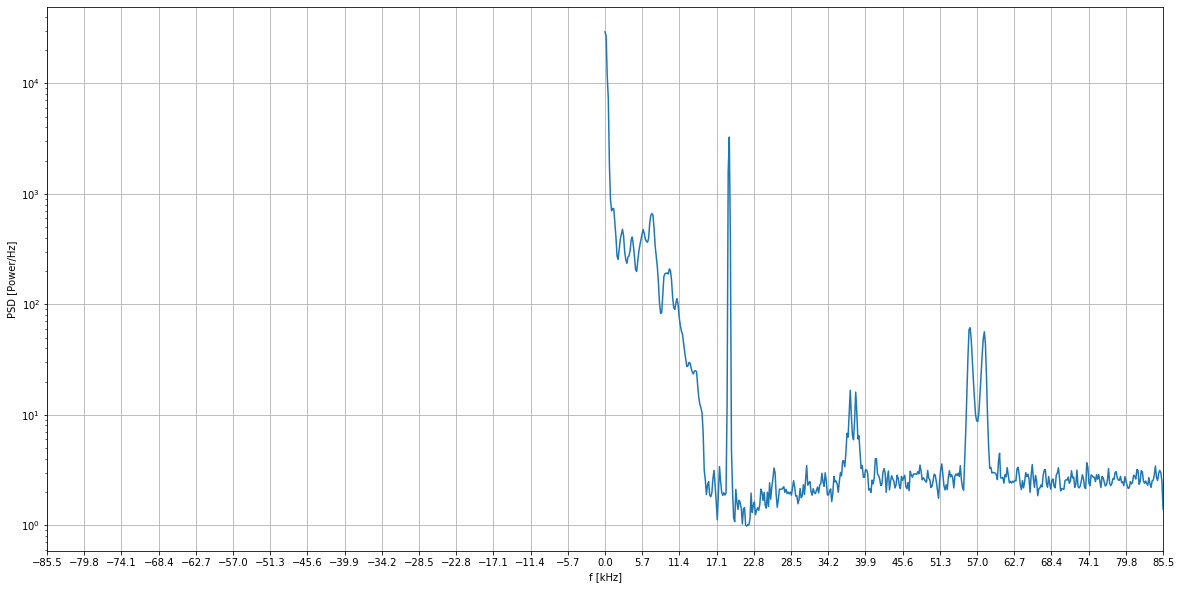

In [4]:
sample_rate = 171000
welch(samples, sample_rate)

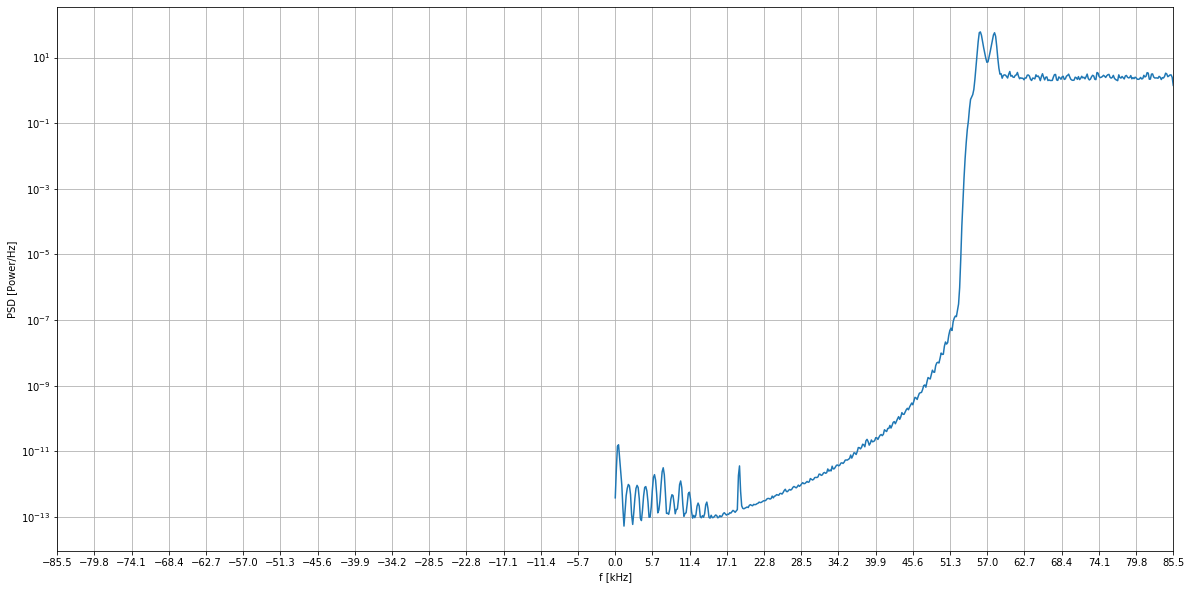

In [5]:
# MathWorks suggests +/- 2.4 kHz.
lp = WSFilter(257, 1, 59400 / sample_rate, lowpass=True)
hp = WSFilter(257, 1, 54600 / sample_rate, lowpass=False)
rds_hp = hp.real_run(samples)
welch(rds_hp, sample_rate)

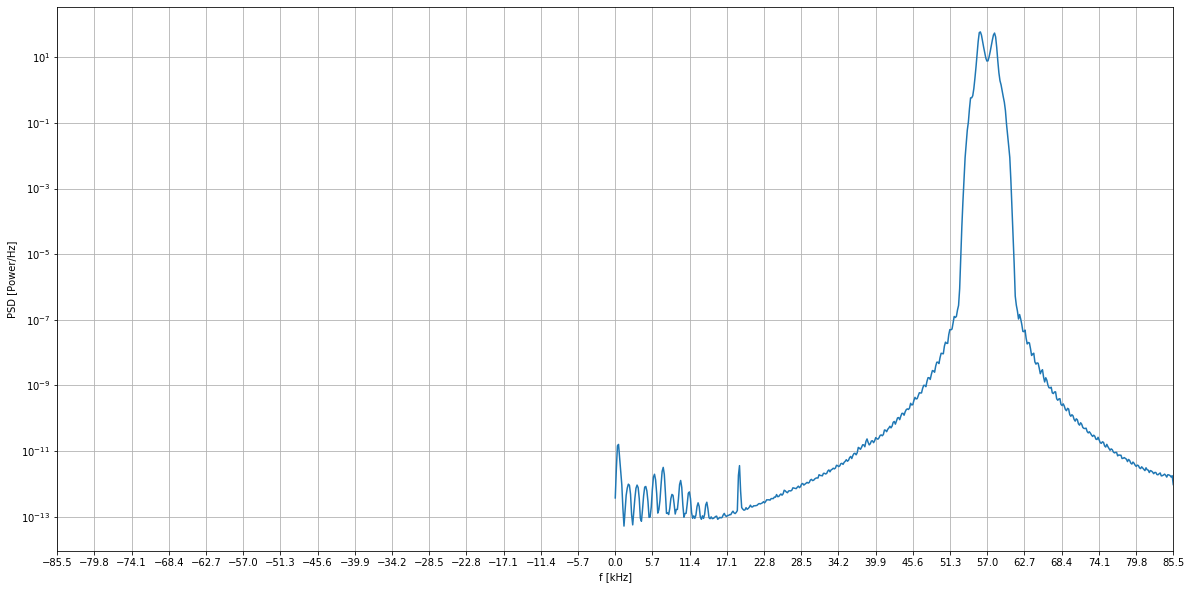

In [7]:
rds_bp = lp.real_run(rds_hp)
welch(rds_bp, sample_rate)

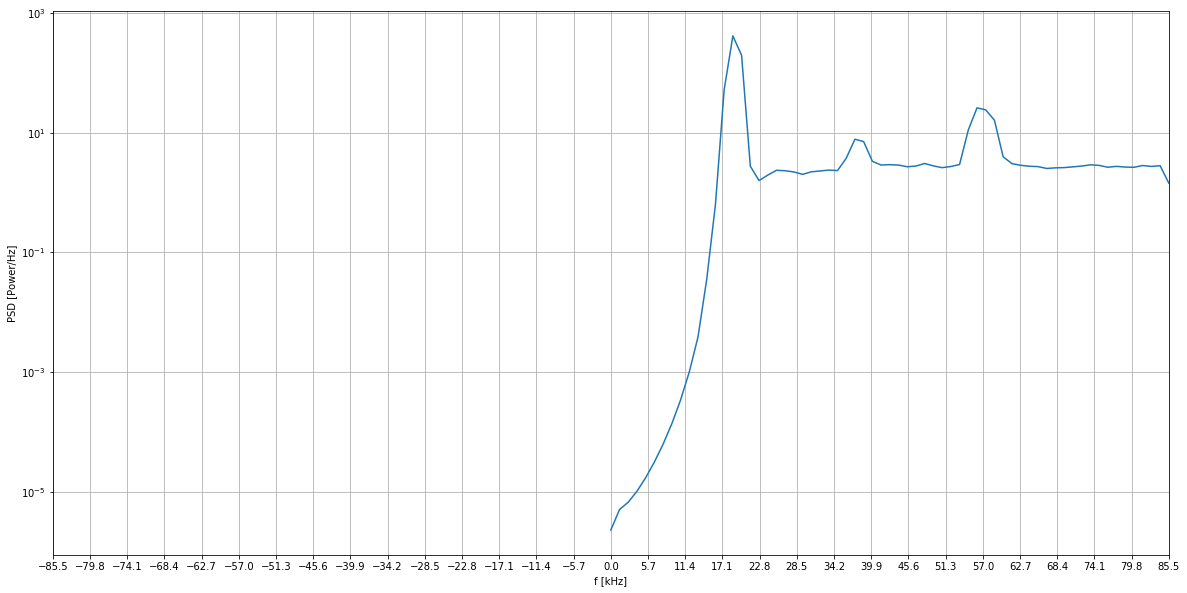

In [8]:
lp = WSFilter(257, 1, 21400 / sample_rate, lowpass=True)
hp = WSFilter(257, 1, 16600 / sample_rate, lowpass=False)
pilot_hp = hp.real_run(samples)
welch(pilot_hp, sample_rate, nper=128)

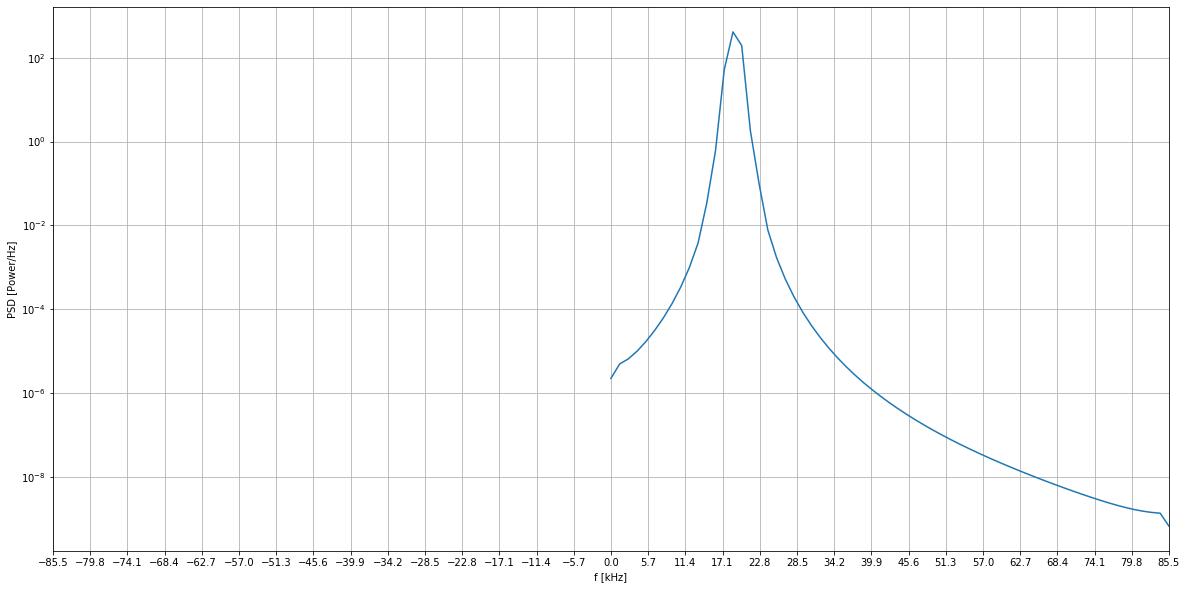

In [11]:
pilot_bp = lp.real_run(pilot_hp)
welch(pilot_bp, sample_rate, nper=128)

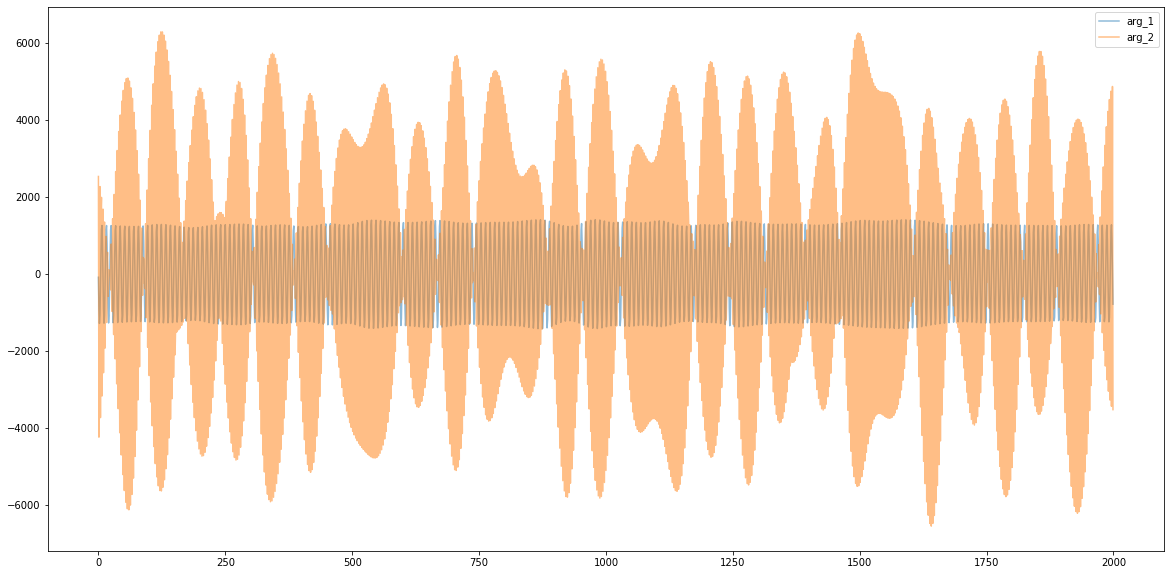

In [12]:
plot_some([pilot_bp, 10 * rds_bp], 61000, 2000)

In [13]:
gain = 0.08
alpha2 = 0.2
agc2 = AGC(gain, alpha2)
agc_pilot = agc2.run(pilot_bp)

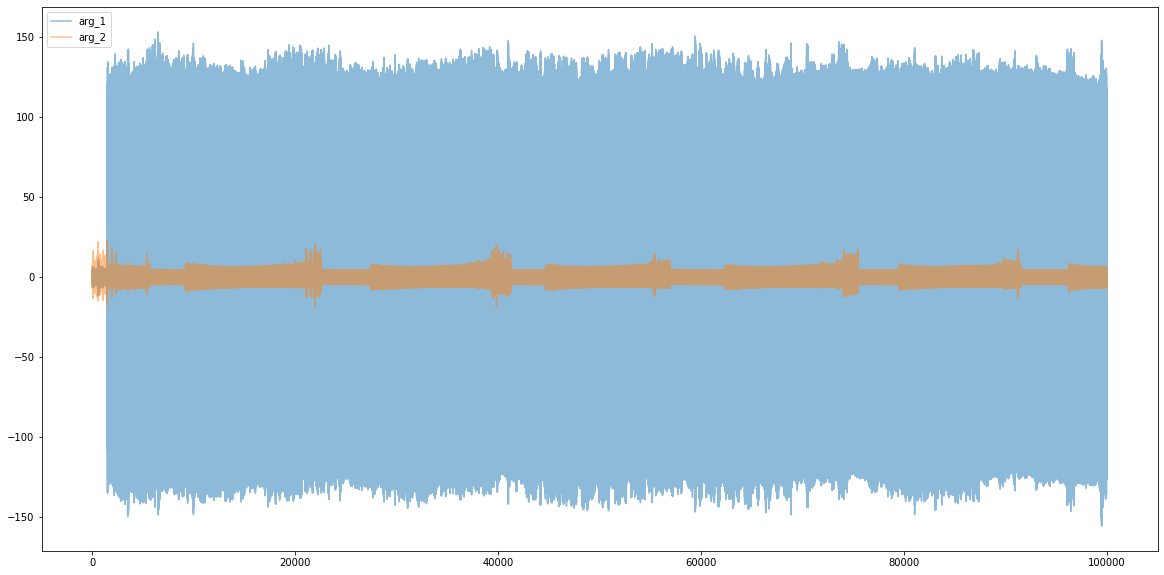

In [16]:
plot_some([0.1 * pilot_bp, agc_pilot], 10000, 100000)

In [17]:
fq = 19000
pll = PLL_2(fq=fq, fs=sample_rate, Bn=0.01)

locked_pilot_phase_agc, agc_errors, agc_corrs = pll.run(agc_pilot)
locked_carrier_agc = np.array([np.cos(p) for p in locked_pilot_phase_agc])

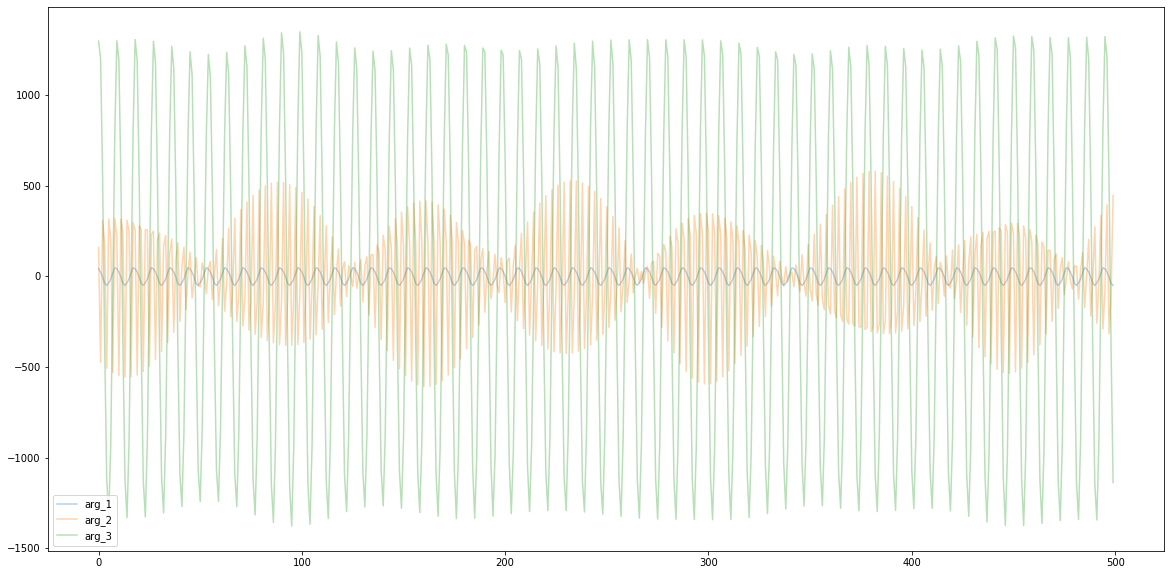

In [20]:
plot_some([50 * locked_carrier_agc, rds_bp, pilot_bp], 20000, 500)

Noticed:
  * Phase error goes wild when amplitude increases (obviously, phase error detector depends on the phase - simple multiplication).
  * Applying AGC to pilot before locking the loop helps TREMENDOUSLY. 

In [21]:
reference_rds_carrier = np.array([np.cos(3 * p) for p in locked_pilot_phase_agc])

In [23]:
M = 1
am_demod = AMDemodulator(4800, sample_rate, M, agc=False)
rds_demod = am_demod.run(rds_bp, reference_rds_carrier)

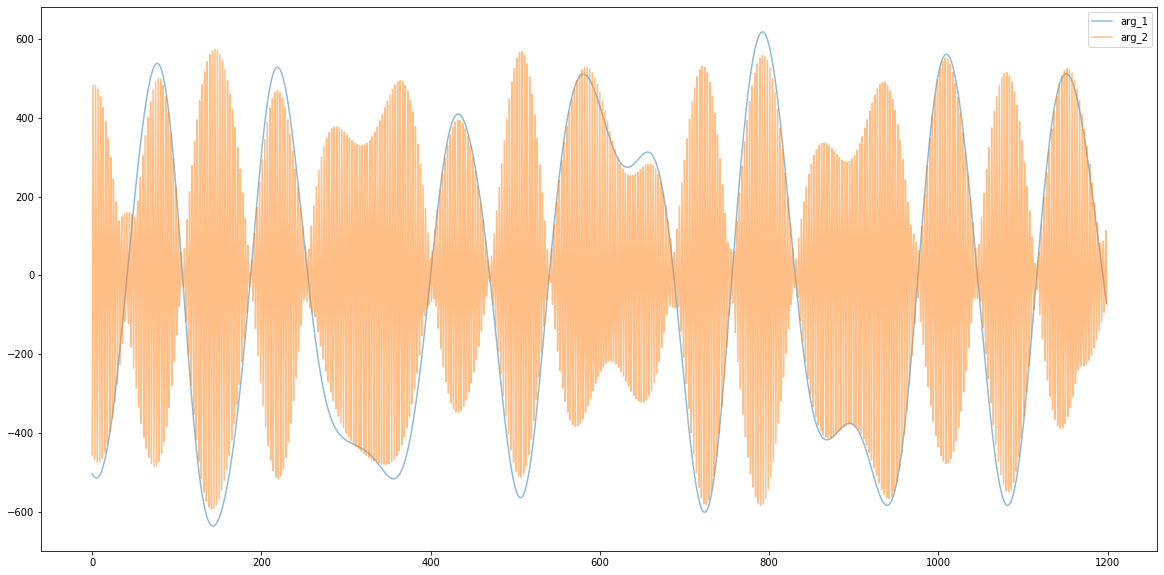

In [31]:
plot_some([rds_demod, rds_bp[128:]], 61070, 1200)  # TODO: why 128??
# plot_some([-rds_demod, rds_bp[128:]], 161070, 1800)

In [35]:
np.save(join(root_path, 'data/rds_am_demod_product'), rds_demod)

### Now let's try a complex envelope detector.

In [33]:
# TODO: write such a detector...